## Лабораторная работа по курсу "Искусственный интеллект"
## Многослойный персептрон

| Студент | Воронов |
|---------|--------|
| Группа  |7      |

Для начала, скачаем датасет MNIST. Используйте `wget` или `curl`, либо скачайте вручную [по ссылке](https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/Data/MNIST/mnist.pkl.gz).

In [125]:
import pylab
import torch
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import train_test_split
import random
torch.__version__


'1.10.0+cu111'

In [ ]:
#!wget https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/Data/MNIST/mnist.pkl.gz
!curl -o mnist.pkl.gz https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/Data/MNIST/mnist.pkl.gz
!gzip -d mnist.pkl.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  9.9M  100  9.9M    0     0  11.6M      0 --:--:-- --:--:-- --:--:-- 11.6M


Теперь загружаем датасет:

In [ ]:
import pickle
with open('mnist.pkl','rb') as f:
    MNIST = pickle.load(f)

In [ ]:
labels = MNIST['Train']['Labels']
data = MNIST['Train']['Features']

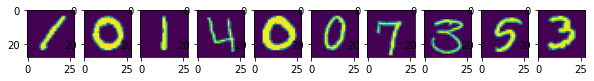

In [ ]:
fig = pylab.figure(figsize=(10, 5))
for i in range(10):
    ax = fig.add_subplot(1,10, i + 1)
    pylab.imshow(data[i].reshape(28, 28))
pylab.show()

In [ ]:
data.shape

(42000, 784)

Используйте Scikit Learn для разбиения данных на обучающую и тестовую выборку

In [ ]:
train_x, test_x, train_labels, test_labels = sklearn.model_selection.train_test_split(data, labels, test_size = 0.2, train_size = 0.8, shuffle = False)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

datasettrain = torch.utils.data.TensorDataset(torch.tensor(train_x, dtype = torch.float32),torch.tensor(train_labels, dtype = torch.float32, device=device))
dataloadertrain = torch.utils.data.DataLoader(datasettrain, batch_size = 4)

val_x = torch.tensor(train_x, dtype = torch.float32, device=device)
val_lab = torch.tensor(train_labels, dtype = torch.float32, device=device)
test_tens_x = torch.tensor(test_x, dtype = torch.float32, device=device)
test_tens_l = torch.tensor(test_labels, dtype = torch.float32, device=device)

list(dataloadertrain)[0]

[tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([1., 0., 1., 4.])]

## Основные функции

In [ ]:
def debug_acc(net, val_x, val_lab, ep, loss):
    k = 0
    a = net(val_x.float())
    for i in range(val_lab.size(0)):
        b = torch.argmax(a[i])
        if b == val_lab[i]:
            k += 1
    print(f"Epoch {ep}: last batch loss = {loss}, val acc = {k / val_lab.size(0)}")
    
def acc_loss(net, x, y, loss):
    k = 0
    z = net(x)
    f = make_target(y, z)
    l = loss(z, f)
    for i in range(x.size(0)):
        b = torch.argmax(z[i])
        if b == y[i]:
            k += 1
    return l, k / x.size(0)
    
def make_target(old_y, z):
    y = torch.tensor((), dtype = torch.float32).new_zeros(z.size())
    for i in range(z.size(0)):
        y[i][old_y[i].long().item()] = 1
    return y

In [ ]:
def train(net, test_tens_x, test_tens_l, l, dataloader, val_x, val_lab,  optim, epochs = 10):
    for ep in range(epochs):
        loss = 0
        for (x, y) in dataloader: 
            z = net(x)
            y = make_target(y, z)
            loss = l(z, y)
            optim.zero_grad()
            loss.backward()
            optim.step()
        ls, ac = acc_loss(net, val_x, val_lab, l)
        graphics[0].append(ac)
        ls, ac = acc_loss(net, test_tens_x, test_tens_l, l)
        graphics[1].append(ac)
        #debug_acc(net, val_x, val_lab, ep, loss)
    return graphics

In [ ]:
def draw_confusion_matrix_and_graphics(net, x, labels, n, graphics):
    z = net(x)
    res = []
    for i in range(z.size(0)):
        res.append(torch.argmax(z[i]).item())

    con_matrix = []
    for i in range(n):
        con_matrix.append([0] * n)
            
    for i in range(len(res)):
        con_matrix[res[i]][labels[i].long().item()] += 1
            
    figure = plt.figure(figsize = (17, 5))
    axes = figure.add_subplot(121)
    caxes = axes.matshow(con_matrix)
    figure.colorbar(caxes)
        
    axes = figure.add_subplot(122)
    plt.plot(graphics[0], 'r')
    plt.plot(graphics[1], 'b')
    plt.show()

## Однослойная сеть

Алгоритм оптимизации - Adam

Шаг обучения - 0.00075

Количество эпох - 10

Размер батча - 4

Функция потерь - cross_entropy

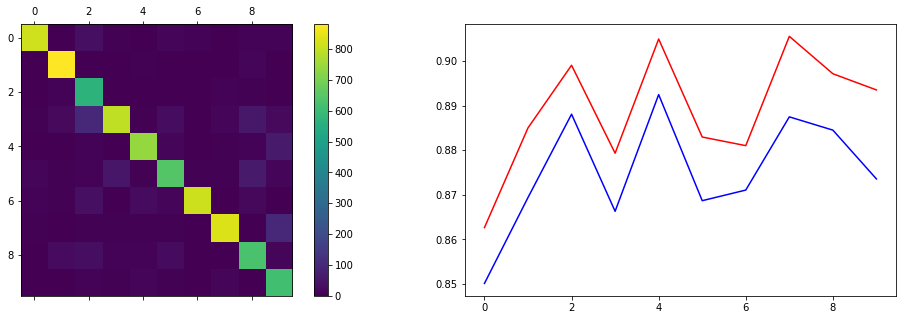

Final loss=10.181845664978027, accuracy=0.8935416666666667: 
Test loss=13.723917961120605, accuracy=0.8735714285714286: 


In [ ]:
net = torch.nn.Linear(784, 10)
optim = torch.optim.Adam(net.parameters(), lr = 0.00075)

loss = torch.nn.functional.cross_entropy

graphics = [[], []]
graphics = train(net, test_tens_x, test_tens_l, loss, dataloadertrain, val_x, val_lab, optim, epochs = 10)
draw_confusion_matrix_and_graphics(net, test_tens_x, test_tens_l, 10, graphics)

print("Final loss={}, accuracy={}: ".format(*acc_loss(net, val_x, val_lab, loss)))
print("Test loss={}, accuracy={}: ".format(*acc_loss(net, test_tens_x, test_tens_l, loss)))

Алгоритм оптимизации - Adagrad

Шаг обучения - 0.01

Размер батча - 1

Количество эпох - 20

Функция потерь - mse_loss

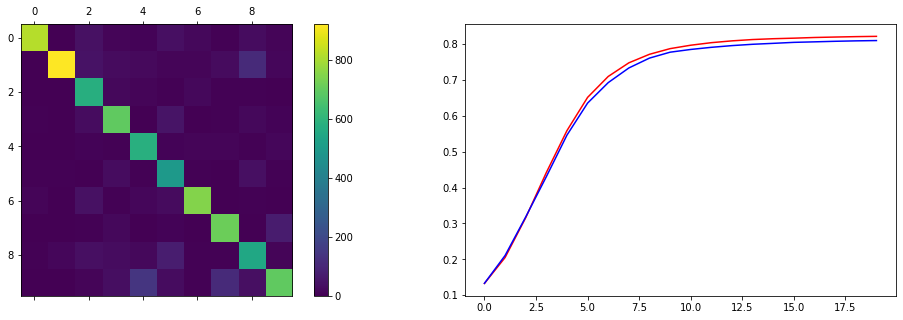

Final loss=0.0460619181394577, accuracy=0.82125: 
Test loss=0.04967803508043289, accuracy=0.8095238095238095: 


In [ ]:
net = torch.nn.Linear(784, 10)
optim = torch.optim.Adagrad(net.parameters(), lr = 0.01)
dataloadertrain = torch.utils.data.DataLoader(datasettrain, batch_size = 1)
loss = torch.nn.functional.mse_loss

graphics = [[], []]
graphics = train(net, test_tens_x, test_tens_l, loss, dataloadertrain, val_x, val_lab, optim, epochs = 20)
draw_confusion_matrix_and_graphics(net, test_tens_x, test_tens_l, 10, graphics)

print("Final loss={}, accuracy={}: ".format(*acc_loss(net, val_x, val_lab, loss)))
print("Test loss={}, accuracy={}: ".format(*acc_loss(net, test_tens_x, test_tens_l, loss)))

# Многослойная сеть

Алгоритм оптимизации - Adam

Шаг обучения - 0.00001

Размер батча - 4

Количество линейных слоёв - 2

Предаточная функция - Sigmoid

Количество эпох - 10

Функция потерь - cross_entropy

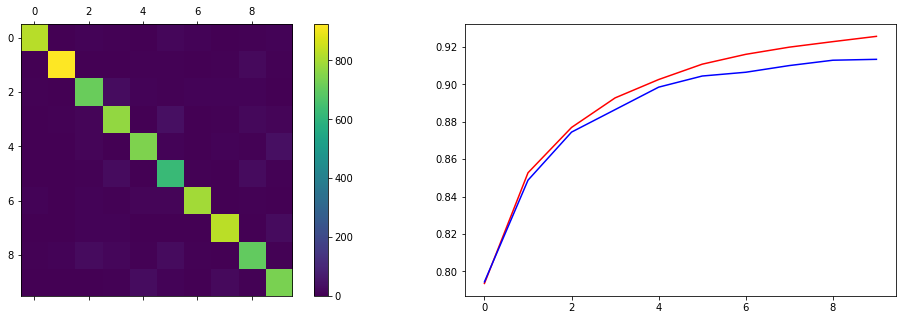

Final loss=0.29060378670692444, accuracy=0.9257440476190476: 
Test loss=0.3179645538330078, accuracy=0.9134523809523809: 


In [ ]:
net = torch.nn.Sequential(torch.nn.Linear(784, 100),torch.nn.Sigmoid(),torch.nn.Linear(100, 10))
optim = torch.optim.Adam(net.parameters(), lr = 0.00001)
dataloadertrain = torch.utils.data.DataLoader(datasettrain, batch_size = 4)
loss = torch.nn.functional.cross_entropy

graphics = [[], []]
graphics = train(net, test_tens_x, test_tens_l, loss, dataloadertrain, val_x, val_lab, optim, epochs = 10)
draw_confusion_matrix_and_graphics(net, test_tens_x, test_tens_l, 10, graphics)

print("Final loss={}, accuracy={}: ".format(*acc_loss(net, val_x, val_lab, loss)))
print("Test loss={}, accuracy={}: ".format(*acc_loss(net, test_tens_x, test_tens_l, loss)))

Алгоритм оптимизации - RMSprop

Шаг обучения - 0.00001

Размер батча - 2

Количество линейных слоёв - 3

Предаточная функция - ReLU

Количество эпох - 10

Функция потерь - cross_entropy

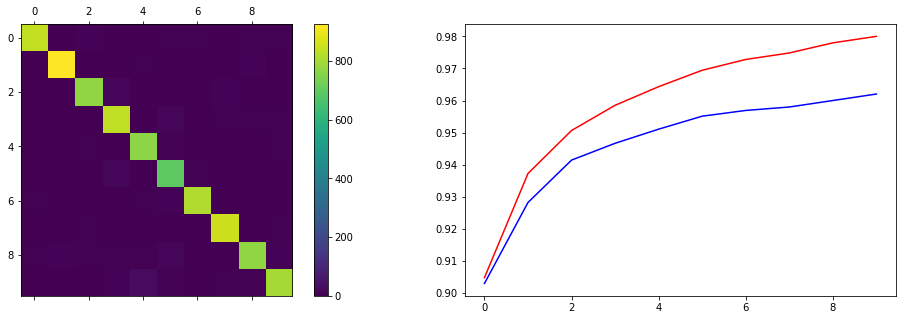

Final loss=0.015613763593137264, accuracy=0.98: 
Test loss=0.02854682318866253, accuracy=0.9620238095238095: 


In [ ]:
net = torch.nn.Sequential(torch.nn.Linear(784, 100), torch.nn.ReLU(), torch.nn.Linear(100, 80), torch.nn.ReLU(), torch.nn.Linear(80, 10))

optim = torch.optim.RMSprop(net.parameters(), lr = 0.00001)
dataloadertrain = torch.utils.data.DataLoader(datasettrain, batch_size = 2)
loss = torch.nn.functional.cross_entropy

graphics = [[], []]
graphics = train(net, test_tens_x, test_tens_l, loss, dataloadertrain, val_x, val_lab, optim, epochs = 10)
draw_confusion_matrix_and_graphics(net, test_tens_x, test_tens_l, 10, graphics)

print("Final loss={}, accuracy={}: ".format(*acc_loss(net, val_x, val_lab, loss)))
print("Test loss={}, accuracy={}: ".format(*acc_loss(net, test_tens_x, test_tens_l, loss)))

# FashionMNIST

In [ ]:
!rm -rf *.gz

!curl -o test-images.gz https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/data/fashion/t10k-images-idx3-ubyte.gz
!curl -o test-labels.gz https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/data/fashion/t10k-labels-idx1-ubyte.gz
!curl -o train-images.gz https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/data/fashion/train-images-idx3-ubyte.gz
!curl -o train-labels.gz https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/data/fashion/train-labels-idx1-ubyte.gz

import gzip
with gzip.open("test-labels.gz", "rb") as gz:
    test_labels = np.frombuffer(gz.read(), dtype=np.uint8, offset=8)
with gzip.open("test-images.gz", "rb") as gz:
    test_x = np.frombuffer(gz.read(), dtype=np.uint8, offset=16).reshape(len(test_labels), 784)
    
with gzip.open("train-labels.gz", "rb") as gz:
    train_labels = np.frombuffer(gz.read(), dtype=np.uint8, offset=8)
with gzip.open("train-images.gz", "rb") as gz:
    train_x = np.frombuffer(gz.read(), dtype=np.uint8, offset=16).reshape(len(train_labels), 784)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4318k  100 4318k    0     0  9053k      0 --:--:-- --:--:-- --:--:-- 9034k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5148  100  5148    0     0  26000      0 --:--:-- --:--:-- --:--:-- 26000
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 25.1M  100 25.1M    0     0  9248k      0  0:00:02  0:00:02 --:--:-- 9244k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 29515  100 29515    0     0   162k      0 --:--:-- --:--:-- --:--:--  162k


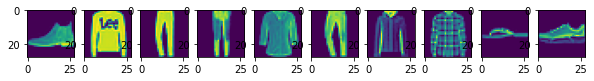

In [ ]:
fig = pylab.figure(figsize=(10,5))
for i in range(10):
    ax = fig.add_subplot(1,10,i+1)
    pylab.imshow(test_x[i].reshape(28,28))
pylab.show()

In [ ]:
datasettrain = torch.utils.data.TensorDataset(torch.tensor(train_x, dtype = torch.float32),torch.tensor(train_labels, dtype = torch.float32, device=device))
dataloadertrain = torch.utils.data.DataLoader(datasettrain, batch_size = 4)

val_x = torch.tensor(train_x, dtype = torch.float32, device=device)
val_lab = torch.tensor(train_labels, dtype = torch.float32, device=device)
test_tens_x = torch.tensor(test_x, dtype = torch.float32, device=device)
test_tens_l = torch.tensor(test_labels, dtype = torch.float32, device=device)

Алгоритм оптимизации - RMSprop

Шаг обучения - 0.005

Размер батча - 4

Количество эпох - 10

Функция потерь - multilabel_soft_margin_loss

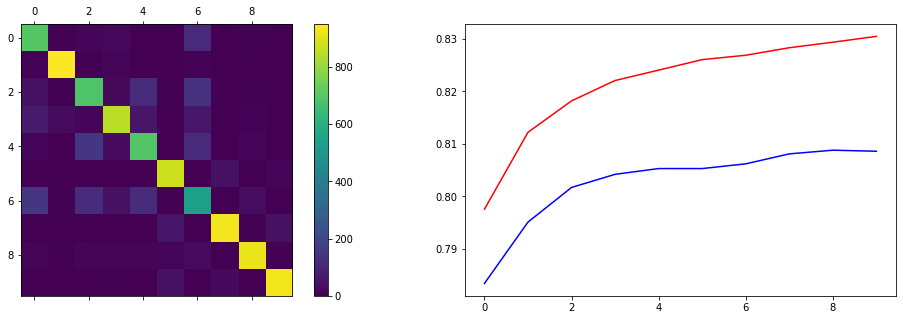

Final loss=0.20731210708618164, accuracy=0.8305: 
Test loss=0.26448386907577515, accuracy=0.8086: 


In [ ]:
net = torch.nn.Linear(784, 10)
optim = torch.optim.Adagrad(net.parameters(), lr = 0.005)

loss = torch.nn.functional.multilabel_soft_margin_loss

graphics = [[], []]
graphics = train(net, test_tens_x, test_tens_l, loss, dataloadertrain, val_x, val_lab, optim, epochs = 10)
draw_confusion_matrix_and_graphics(net, test_tens_x, test_tens_l, 10, graphics)

print("Final loss={}, accuracy={}: ".format(*acc_loss(net, val_x, val_lab, loss)))
print("Test loss={}, accuracy={}: ".format(*acc_loss(net, test_tens_x, test_tens_l, loss)))

Алгоритм оптимизации - Adadelta

Шаг обучения - 0.01

Размер батча - 4

Количество эпох - 10

Функция потерь - cross_entropy

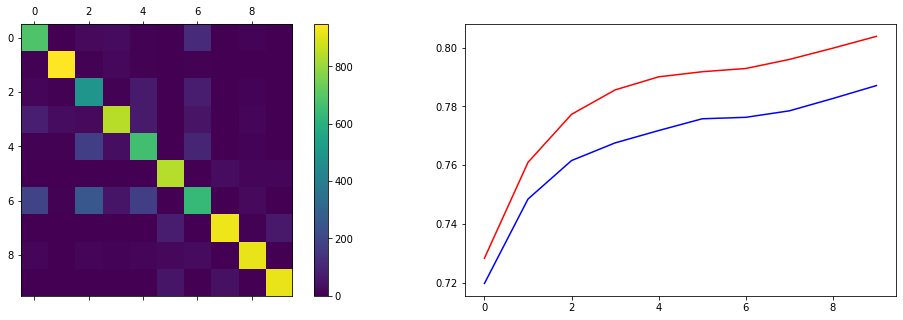

Final loss=2.6685311794281006, accuracy=0.8038333333333333: 
Test loss=3.104912042617798, accuracy=0.7871: 


In [ ]:
net = torch.nn.Linear(784, 10)
optim = torch.optim.Adadelta(net.parameters(), lr = 0.01)

loss = torch.nn.functional.cross_entropy

graphics = [[], []]
graphics = train(net, test_tens_x, test_tens_l, loss, dataloadertrain, val_x, val_lab, optim, epochs = 10)
draw_confusion_matrix_and_graphics(net, test_tens_x, test_tens_l, 10, graphics)

print("Final loss={}, accuracy={}: ".format(*acc_loss(net, val_x, val_lab, loss)))
print("Test loss={}, accuracy={}: ".format(*acc_loss(net, test_tens_x, test_tens_l, loss)))

Алгоритм оптимизации - Adagrad

Шаг обучения - 0.001

Размер батча - 2

Количество линейных слоёв - 2

Предаточная функция - ReLU6

Количество эпох - 10

Функция потерь - poisson_nll_loss

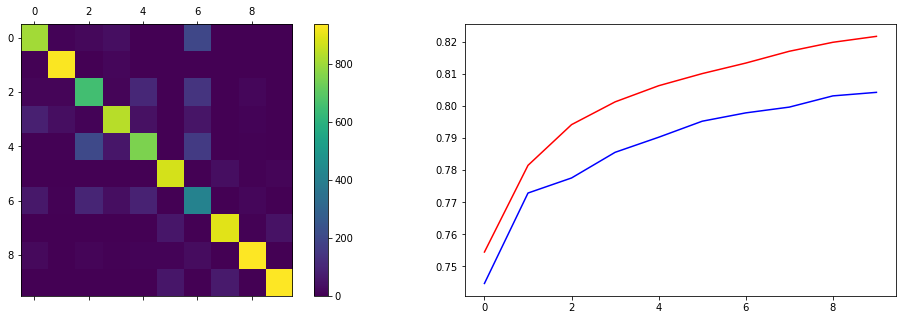

Final loss=0.158162459731102, accuracy=0.8217666666666666: 
Test loss=0.1629076898097992, accuracy=0.8043: 


In [ ]:
net = torch.nn.Sequential(torch.nn.Linear(784, 85),torch.nn.ReLU6(),torch.nn.Linear(85, 10))
optim = torch.optim.Adagrad(net.parameters(), lr = 0.001)
dataloadertrain = torch.utils.data.DataLoader(datasettrain, batch_size = 2)
loss = torch.nn.functional.poisson_nll_loss

graphics = [[], []]
graphics = train(net, test_tens_x, test_tens_l, loss, dataloadertrain, val_x, val_lab, optim, epochs = 10)
draw_confusion_matrix_and_graphics(net, test_tens_x, test_tens_l, 10, graphics)

print("Final loss={}, accuracy={}: ".format(*acc_loss(net, val_x, val_lab, loss)))
print("Test loss={}, accuracy={}: ".format(*acc_loss(net, test_tens_x, test_tens_l, loss)))

Алгоритм оптимизации - RMSprop

Шаг обучения - 0.0001

Размер батча - 4

Количество линейных слоёв - 3

Предаточная функция - ReLU6, Sigmoid

Количество эпох - 10

Функция потерь - multilabel_soft_margin_loss

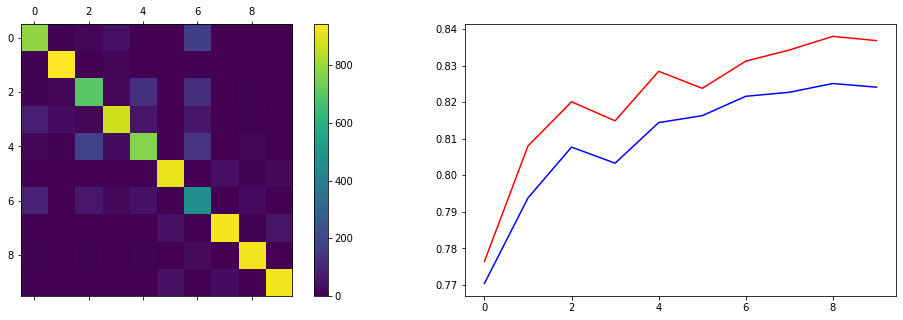

Final loss=0.08143080770969391, accuracy=0.8368333333333333: 
Test loss=0.0879264548420906, accuracy=0.8241: 


In [ ]:
net = torch.nn.Sequential(torch.nn.Linear(784, 100), torch.nn.ReLU6(), torch.nn.Linear(100, 65), torch.nn.Sigmoid(), torch.nn.Linear(65, 10))
optim = torch.optim.RMSprop(net.parameters(), lr = 0.0001)
dataloadertrain = torch.utils.data.DataLoader(datasettrain, batch_size = 4)
loss = torch.nn.functional.multilabel_soft_margin_loss

graphics = [[], []]
graphics = train(net, test_tens_x, test_tens_l, loss, dataloadertrain, val_x, val_lab, optim, epochs = 10)
draw_confusion_matrix_and_graphics(net, test_tens_x, test_tens_l, 10, graphics)

print("Final loss={}, accuracy={}: ".format(*acc_loss(net, val_x, val_lab, loss)))
print("Test loss={}, accuracy={}: ".format(*acc_loss(net, test_tens_x, test_tens_l, loss)))

Алгоритм оптимизации - RMSprop

Шаг обучения - 0.00001

Размер батча - 2

Количество линейных слоёв - 3

Предаточная функция - ReLU

Количество эпох - 10

Функция потерь - cross_entropy

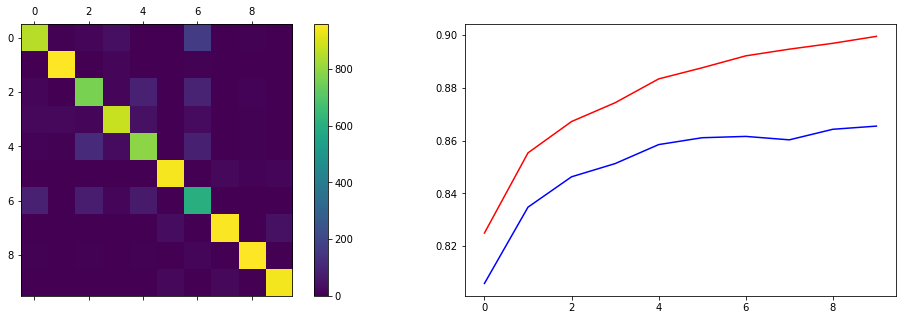

Final loss=0.2965249717235565, accuracy=0.8995: 
Test loss=0.4324435591697693, accuracy=0.8655: 


In [ ]:
net = torch.nn.Sequential(torch.nn.Linear(784, 100), torch.nn.ReLU(), torch.nn.Linear(100, 80), torch.nn.ReLU(), torch.nn.Linear(80, 10))

optim = torch.optim.RMSprop(net.parameters(), lr = 0.00001)
dataloadertrain = torch.utils.data.DataLoader(datasettrain, batch_size = 2)
loss = torch.nn.functional.cross_entropy

graphics = [[], []]
graphics = train(net, test_tens_x, test_tens_l, loss, dataloadertrain, val_x, val_lab, optim, epochs = 10)
draw_confusion_matrix_and_graphics(net, test_tens_x, test_tens_l, 10, graphics)

print("Final loss={}, accuracy={}: ".format(*acc_loss(net, val_x, val_lab, loss)))
print("Test loss={}, accuracy={}: ".format(*acc_loss(net, test_tens_x, test_tens_l, loss)))

 # CIFAR-10

In [126]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [127]:
!curl -o cifar.gz https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
import gzip
!tar -xvf cifar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  162M  100  162M    0     0  23.5M      0  0:00:06  0:00:06 --:--:-- 30.1M
cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [128]:
a = unpickle("/content/cifar-10-batches-py/data_batch_1")
train_x = a[b'data']
train_labels = a[b'labels']

a = unpickle("/content/cifar-10-batches-py/data_batch_2")
train_x = np.concatenate((train_x , a[b'data']), axis = 0)
train_labels = np.append(train_labels, a[b'labels'])

a = unpickle("/content/cifar-10-batches-py/data_batch_3")
train_x = np.concatenate((train_x , a[b'data']), axis = 0)
train_labels = np.append(train_labels, a[b'labels'])

a = unpickle("/content/cifar-10-batches-py/data_batch_4")
train_x = np.concatenate((train_x , a[b'data']), axis = 0)
train_labels = np.append(train_labels, a[b'labels'])

a = unpickle("/content/cifar-10-batches-py/data_batch_5")
train_x = np.concatenate((train_x , a[b'data']), axis = 0)
train_labels = np.append(train_labels, a[b'labels'])

a = unpickle("/content/cifar-10-batches-py/test_batch")
test_x = a[b'data']
test_labels = a[b'labels']

In [129]:
for i in range(len(train_x)):
    train_x[i] = np.concatenate(train_x[i].reshape(3, 32, 32, 1), axis=2).reshape(-1,)

for i in range(len(test_x)):
    test_x[i] = np.concatenate(test_x[i].reshape(3, 32, 32, 1), axis=2).reshape(-1,)

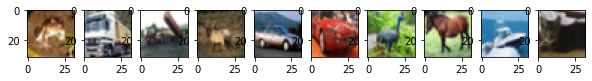

In [130]:
fig = pylab.figure(figsize=(10,5))
for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    pylab.imshow(train_x[i].reshape(32, 32, 3))
pylab.show()

In [131]:
datasettrain = torch.utils.data.TensorDataset(torch.tensor(train_x, dtype = torch.float32),torch.tensor(train_labels, dtype = torch.float32, device=device))
dataloadertrain = torch.utils.data.DataLoader(datasettrain, batch_size = 4)

val_x = torch.tensor(train_x, dtype = torch.float32, device=device)
val_lab = torch.tensor(train_labels, dtype = torch.float32, device=device)
test_tens_x = torch.tensor(test_x, dtype = torch.float32, device=device)
test_tens_l = torch.tensor(test_labels, dtype = torch.float32, device=device)

Алгоритм оптимизации - Adagrad

Шаг обучения - 0.5

Размер батча - 4

Количество эпох - 20

Функция потерь - cross_entropy

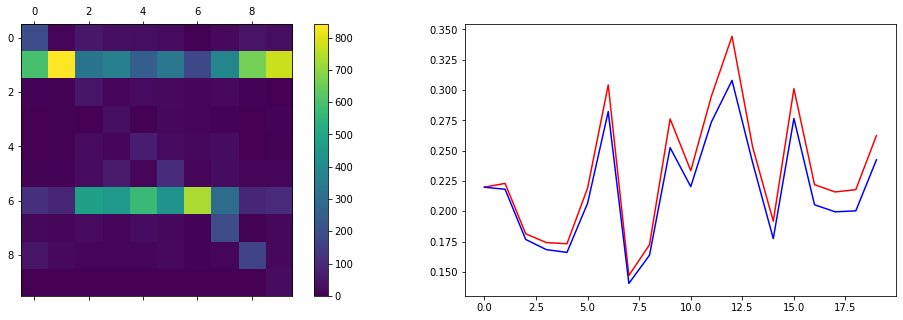

Final loss=482.0293884277344, accuracy=0.26242: 
Test loss=541.8480224609375, accuracy=0.2424: 


In [132]:
net = torch.nn.Linear(3072, 10)
optim = torch.optim.Adagrad(net.parameters(), lr = 0.5)

loss = torch.nn.functional.cross_entropy

graphics = [[], []]
graphics = train(net, test_tens_x, test_tens_l, loss, dataloadertrain, val_x, val_lab, optim, epochs = 20)
draw_confusion_matrix_and_graphics(net, test_tens_x, test_tens_l, 10, graphics)

print("Final loss={}, accuracy={}: ".format(*acc_loss(net, val_x, val_lab, loss)))
print("Test loss={}, accuracy={}: ".format(*acc_loss(net, test_tens_x, test_tens_l, loss)))

Алгоритм оптимизации - RMSprop

Шаг обучения - 0.00001

Размер батча - 20

Количество линейных слоёв - 3

Предаточная функция - ReLU

Количество эпох - 10

Функция потерь - cross_entropy

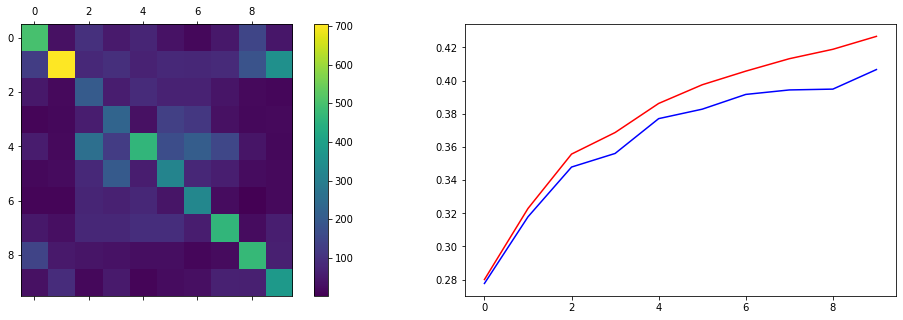

Final loss=1.6227505207061768, accuracy=0.42672: 
Test loss=1.6930019855499268, accuracy=0.4067: 


In [133]:
net = torch.nn.Sequential(torch.nn.Linear(3072, 100), torch.nn.ReLU(), torch.nn.Linear(100, 80), torch.nn.ReLU(), torch.nn.Linear(80, 10))

optim = torch.optim.RMSprop(net.parameters(), lr = 0.00001)
dataloadertrain = torch.utils.data.DataLoader(datasettrain, batch_size = 20)
loss = torch.nn.functional.cross_entropy

graphics = [[], []]
graphics = train(net, test_tens_x, test_tens_l, loss, dataloadertrain, val_x, val_lab, optim, epochs = 10)
draw_confusion_matrix_and_graphics(net, test_tens_x, test_tens_l, 10, graphics)

print("Final loss={}, accuracy={}: ".format(*acc_loss(net, val_x, val_lab, loss)))
print("Test loss={}, accuracy={}: ".format(*acc_loss(net, test_tens_x, test_tens_l, loss)))

Алгоритм оптимизации - RMSprop

Шаг обучения - 0.00001

Размер батча - 50

Количество линейных слоёв - 3

Предаточная функция - ReLU

Количество эпох - 10

Функция потерь - cross_entropy

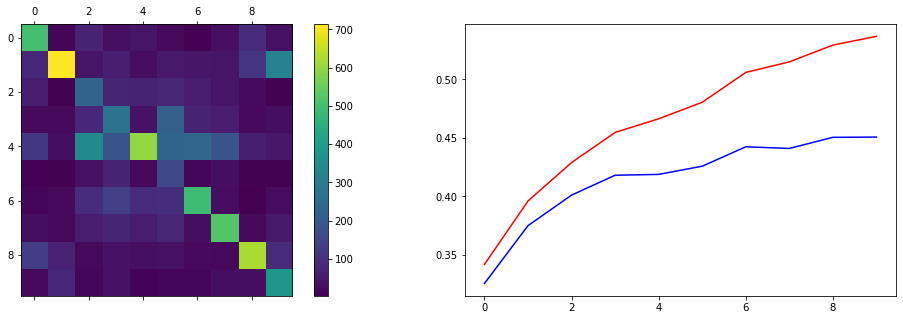

Final loss=1.31488037109375, accuracy=0.5368: 
Test loss=1.6323882341384888, accuracy=0.4507: 


In [134]:
net = torch.nn.Sequential(torch.nn.Linear(3072, 1000), torch.nn.ReLU(), torch.nn.Linear(1000, 500), torch.nn.ReLU(), torch.nn.Linear(500, 10))

optim = torch.optim.RMSprop(net.parameters(), lr = 0.00001)
dataloadertrain = torch.utils.data.DataLoader(datasettrain, batch_size = 50)
loss = torch.nn.functional.cross_entropy

graphics = [[], []]
graphics = train(net, test_tens_x, test_tens_l, loss, dataloadertrain, val_x, val_lab, optim, epochs = 10)
draw_confusion_matrix_and_graphics(net, test_tens_x, test_tens_l, 10, graphics)

print("Final loss={}, accuracy={}: ".format(*acc_loss(net, val_x, val_lab, loss)))
print("Test loss={}, accuracy={}: ".format(*acc_loss(net, test_tens_x, test_tens_l, loss)))